In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading of the data

In [4]:
Xtr = np.array(pd.read_csv('Xtr.csv',header=None,sep=',',usecols=range(3072)))
Xte = np.array(pd.read_csv('Xte.csv',header=None,sep=',',usecols=range(3072)))
Ytr = np.array(pd.read_csv('Ytr.csv',sep=',',usecols=[1])).squeeze()

## Visualization of the data

Each row (3072 values) corresponds to the intensities of the successive 1024 (32x22) red, green and blue pixels. These values roughly range between -0.5 and 0.5. I first assumed that the dataset was large enough to consider that the minimum and maximum values found in the data for each channel corresponded to the 0 and 1 values intensity in the common intensity scale used for images.

In [3]:
I_r_min = min(np.min(Xtr[:, :1024]), np.min(Xte[:, :1024]))
I_r_max = max(np.max(Xtr[:, :1024]), np.max(Xte[:, :1024]))

I_g_min = min(np.min(Xtr[:, 1024:2048]), np.min(Xte[:, 1024:2048]))
I_g_max = max(np.max(Xtr[:, 1024:2048]), np.max(Xte[:, 1024:2048]))

I_b_min = min(np.min(Xtr[:, 2048:]), np.min(Xte[:, 2048:]))
I_b_max = max(np.max(Xtr[:, 2048:]), np.max(Xte[:, 2048:]))

print('Minimum intensity for the red channel : ', round(I_r_min, 2))
print('Maximum intensity for the red channel : ', round(I_r_max, 2))
print()
print('Minimum intensity for the green channel : ', round(I_g_min, 2))
print('Maximum intensity for the green channel : ', round(I_g_max, 2))
print()
print('Minimum intensity for the blue channel : ', round(I_b_min, 2))
print('Maximum intensity for the blue channel : ', round(I_b_max, 2))

Minimum intensity for the red channel :  -0.36
Maximum intensity for the red channel :  0.42

Minimum intensity for the green channel :  -0.49
Maximum intensity for the green channel :  0.36

Minimum intensity for the blue channel :  -0.46
Maximum intensity for the blue channel :  0.38


Yet it appeared that the results were not good, and thus scaling each image the same way does not seem to be adapted to the process used to generate the image.

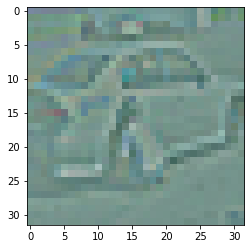

In [4]:
# Exemple of an image generated with the previous process

image = Xtr[3].copy()
image = np.transpose(np.reshape(image, (3, 32, -1)), (1, 2, 0))
    
image[:, :, 0] = (image[:, :, 0] - I_r_min)/(I_r_max-I_r_min)
image[:, :, 1] = (image[:, :, 1] - I_g_min)/(I_g_max-I_g_min)
image[:, :, 2] = (image[:, :, 2] - I_b_min)/(I_b_max-I_b_min)

plt.imshow(image)
plt.show()

I then chosed a simple model in which each image is scaled with its own minimum et maximum intensity values. A mode is added to the image constructor that computes the gray level using the formula : $I_{gray} = 0.2126I_{r} + 0.7152I_{g} + 0.0722I_{b}$

In [6]:
def image_construction(image_vect, mode='rgb'):
    ''' transforms a (3072, ) vector into an (32, 32, 3) RGB image '''
    image = image_vect.copy()
    image = np.transpose(np.reshape(image, (3, 32, -1)), (1, 2, 0))
    
    r_min, r_max = image[:, : , 0].min(), image[:, :, 0].max()
    g_min, g_max = image[:, : , 1].min(), image[:, :, 1].max()
    b_min, b_max = image[:, : , 2].min(), image[:, :, 2].max()
    
    image[:, :, 0] = (image[:, :, 0] - r_min)/(r_max-r_min)
    image[:, :, 1] = (image[:, :, 1] - g_min)/(g_max-g_min)
    image[:, :, 2] = (image[:, :, 2] - b_min)/(b_max-b_min)
    
    if mode == 'rgb':
        return image
    if mode == 'gray':
        return 0.2126*image[:, :, 0] + 0.7152*image[:, :, 1] + 0.0722*image[:, :, 2] 

def plot_image(image_vect, mode='rgb'):
    image = image_construction(image_vect, mode=mode)
    if mode == 'rgb':
        plt.imshow(image)
        plt.show()
    if mode == 'gray':
        plt.imshow(image, cmap='gray')
        plt.show()

def save_image(image_vect, fname, mode='rgb'):
    image = image_construction(image_vect, mode=mode)
    if mode == 'rgb':
        plt.imshow(image)
        plt.savefig(fname=fname, dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)
    if mode == 'gray':
        plt.imshow(image, cmap='gray')
        plt.savefig(fname=fname, dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)

def plot_images_class(X, y, class_idx, n_images):
    ''' get the n_images first images corresponding to class class_idx in X'''
    X_images = X[y==class_idx][:n_images]
    for image_vect in X_images:
        plot_image(image_vect)

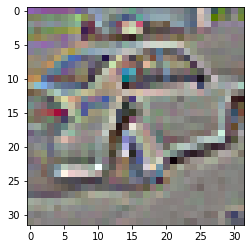

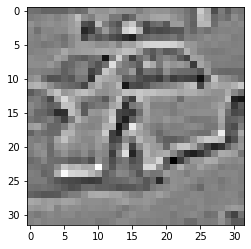

In [279]:
plot_image(Xtr[3], mode='rgb')
plot_image(Xtr[3], mode='gray')

Using the plot_images_class function we can tell what each class number (from 0 to 9) corresponds to :

0 : plane

1 : car

2 : bird

3 : cat

4 : doe

5 : dog

6 : frog

7 : horse

8 : boat

9 : truck

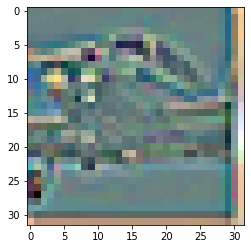

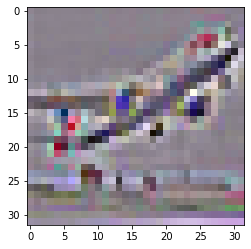

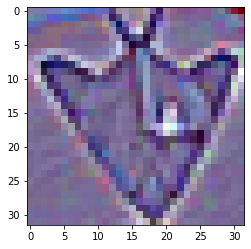

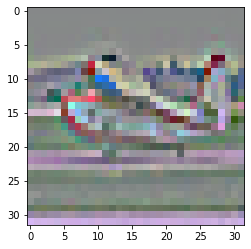

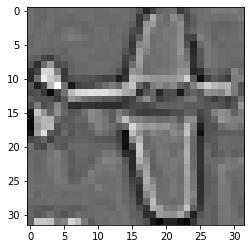

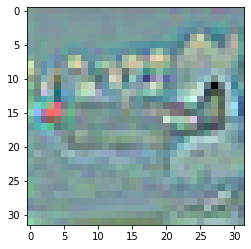

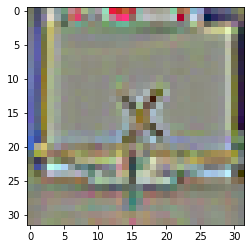

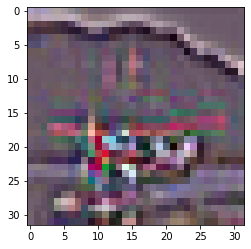

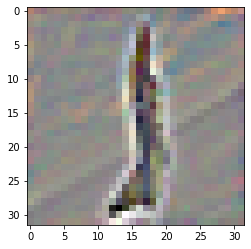

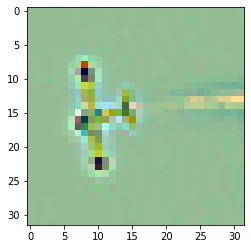

In [280]:
plot_images_class(Xtr, Ytr, class_idx=0, n_images=10)

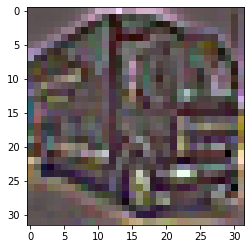

In [239]:
save_image(Xtr[67], fname='9-truck')

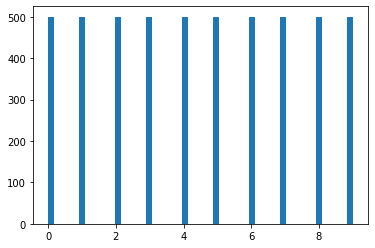

In [281]:
# distribution of the classes in the training set.
plt.hist(Ytr, bins=(50))
plt.show()

The training set is equally balanced in terms of classes samples.

## Kernels

As the method implemented to solve this classification problem must be based on kernels, we first implement three well known kernels, namely linear, polynomial and gaussian.

In [7]:
class linear:
    def __init__(self): 
        self = self
    def kernel(self,X1,X2):
        return X1@X2.T

    
class poly:
    def __init__(self, d=3, c=0):
        self.d = d
        self.c = c
    def kernel(self,X1,X2):
        return (X1@X2.T + self.c)**self.d


class rbf:
    def __init__(self, sigma=1):
        self.sigma = sigma
    def kernel(self,X1,X2):
        n, p = X1.shape 
        m, _ = X2.shape
        X1 = X1.reshape(n,1,p,1)
        X2 = X2.reshape(1,m,p,1)
        A = ((X1-X2).transpose((0, 1, 3, 2))@(X1-X2)).reshape(n,m)
        return np.exp(-A/(2*self.sigma**2))

## KernelSVM

Implementation of kernel SVC using the Lagrange dual formulation :

$$ \underset{\alpha}{\max} L_{dual} = \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{1\leq i, j\leq n} \alpha_i \alpha_j y_i y_j K(x_i, x_j)$$

With the constraints $$
\left\{
    \begin{array}{ll}
        \sum_{i=1}^n \alpha_i y_i =0 \\
        0 \leq \alpha_i \leq C  \mbox{ } \mbox{ }  \mbox{ } \forall 1 \leq i \leq n
    \end{array}
\right.
$$

The support vectors are charaterized by $\alpha_i >0$ and the prediction for an image x is computed using : 

$$\hat{y} = sign( b + \sum_{i, \alpha_i > 0} \alpha_i y_i K(x_i, x))$$ 

Where b is the bias of the classifier computed on the vectors on the margin : $b = \underset{0<\alpha_i < C}{avg}(y_i - \sum_{j} \alpha_j y_j K(x_i, x_j))  $

Since we deal a multiclass problem, we will use a One versus One approach in the SVC, meaning that for each image the algorithm will try every pair of labels and determine if the image is more likely to belong to the first label or the second. Every time a label wins a duel, its score is increased by one and the label that won the most duels is the predicted class of the image.

In [8]:
from scipy.optimize import minimize

In [9]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon=1e-8):
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support_vectors = None
        self.weight = None
        self.b = None
        self.epsilon = epsilon

    
    def fit(self, X, y):
        n = len(y)
        K = self.kernel(X,X)

        def loss(alpha):
            return -np.sum(alpha) + 0.5*(alpha*y)@K@(alpha*y)   # opposite of the loss -> use of a minimizer

        def grad_loss(alpha):
            return -np.ones(n) + np.diag(y)@K@np.diag(y)@alpha
       
        eq_constraint = lambda alpha: (-np.sum(y*alpha)).reshape(1,1)
        jac_eq_constraint = lambda alpha:  -y

        ineq_constraint = lambda alpha:  (np.hstack([self.C*np.ones(n)-alpha,alpha])).reshape(2*n,1)
        jac_ineq_constraint = lambda alpha:   np.vstack((-np.eye(n),np.eye(n)))
        
        constraints = ({'type': 'eq', 'fun': eq_constraint, 'jac': jac_eq_constraint},
                       {'type': 'ineq', 'fun': ineq_constraint , 'jac': jac_ineq_constraint})
        
        self.alpha = minimize(fun=lambda alpha: loss(alpha), x0=np.ones(n), method='SLSQP', 
                          jac=lambda alpha: grad_loss(alpha), constraints=constraints).x
    
        
        margin_vectors_mask = np.logical_and(self.alpha>self.epsilon, self.alpha<self.C-self.epsilon)
        self.b = np.mean((y - (y*self.alpha)@K)[margin_vectors_mask])
        
        support_vectors_mask = (self.alpha>self.epsilon)
        self.support_vectors = X[support_vectors_mask]
        self.weight = y[support_vectors_mask]*self.alpha[support_vectors_mask] # weight vector used for
                                                                               # prediction
        

    def predict(self, X_pred):
        soft_prediction = self.b + self.weight@self.kernel(self.support_vectors, X_pred)
        return np.sign(soft_prediction)

The optimization method 'SLSQP' is used because it is one of the only two methods that can deal with the constraints defined above in the minimize function of scipy (we cannot used the parameter 'bounds' to define the egality constraint).

In [10]:
class KernelSVC_1V1:
    
    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
        self.n_class = 0
        self.binary_classifiers = {}
        
        
    def fit(self, X, y):
        self.n_class = len(np.unique(y))
        
        for class_i in range(self.n_class):
            for class_j in range(class_i+1, self.n_class):
                mask = np.logical_or(y == class_i, y == class_j)
                X_train = X[mask]
                y_train = np.where(y[mask]==class_i, 1, -1)
                clf = KernelSVC(C=self.C, kernel=self.kernel)
                clf.fit(X_train, y_train)
                
                self.binary_classifiers[(class_i, class_j)] = clf
                
    def predict(self, X_pred):
        classes_scores = np.zeros(shape=(X_pred.shape[0], self.n_class))
        
        for class_i in range(self.n_class):
            for class_j in range(class_i+1, self.n_class):
                clf = self.binary_classifiers[(class_i, class_j)]
                duel_i_j = clf.predict(X_pred)
                
                classes_scores[duel_i_j == 1, class_i] += 1  # +1 in class_i in the rows where class_i won
                classes_scores[duel_i_j == -1, class_j] += 1 # +1 in class_j in the rows where class_j won 
                
        return np.argmax(classes_scores, axis=1)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(Xtr[:500], Ytr[:500], test_size=0.25)

In [14]:
kernel = rbf(sigma=5).kernel
model = KernelSVC_1V1(C=1000, kernel=kernel)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
np.sum(y_pred==y_val)/len(y_val)

0.192

As seen on the previous example on a small part of the training data, the KernelSVC gets very poor results. The  19.2% accuracy is almost the best value we can expect, obtained after manual tuning of the hyperparameters.

## HOG features

To improve the performances of the previous Kernel SVC, the data are transformed using the histogram of oriented gradient (HOG) process. The method consists of computing the gradients of the image, their magnitudes and orientations, and to build successive histograms of the distribution of orientations weighted by the magnitudes, on non-overlapping cells. The transformation I implemented can be applied on images with one channel, so here on the gray reconstruction of the images.

In [15]:
from itertools import product

def gray_image_gradient(image):
    grad_x = np.zeros(shape=(32, 32))
    grad_y = np.zeros(shape=(32, 32))
    
    # computation of the gradient along the x and the y axis
    grad_x[:, 1:-1] = image[:, 2:] - image[:, :-2]
    grad_x[:, 0] = image[:, 1] - image[:, 0]
    grad_x[:, -1] = image[:, -1] - image[:, -2]
    
    grad_y[1:-1] = image[2:, :] - image[:-2, :]
    grad_y[0, :] = image[1, :] - image[0, :]
    grad_y[-1, :] = image[-1, :] - image[-2, :]
    
    return grad_x, grad_y


def magnitude_orientation(grad_x, grad_y):
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = (180/np.pi)*np.arctan(grad_y/grad_x) + 90
    
    return magnitude, orientation

def cell_histogram(cell_magnitude, cell_orientation, hist_bins):
    # Builds the histogram of orientations on one given cell
    cell_hist = np.zeros(len(hist_bins))
    
    cell_hist[0]=cell_magnitude[cell_orientation<hist_bins[0]].sum()
    for i in range(1, len(hist_bins)):
        v_min, v_max = hist_bins[i-1], hist_bins[i]
        cell_hist[i] = cell_magnitude[np.logical_and(cell_orientation>=v_min, cell_orientation<v_max)].sum()
        
    return cell_hist

def hog(image, cell_size=(8, 8), n_hist_bins=9):
    
    c = cell_size[0]
    n = 32//c
    
    hist_bins = np.linspace(0, 180, n_hist_bins+1)[1:]
    
    grad_x, grad_y = gray_image_gradient(image)
    magnitude, orientation = magnitude_orientation(grad_x, grad_y)
    
    hog_list = []
    
    for i, j in product(np.arange(n), np.arange(n)):
        cell_magnitude = magnitude[c*i:c*(i+1), c*j:c*(j+1)]
        cell_orientation = orientation[c*i:c*(i+1), c*j:c*(j+1)]
        
        cell_hist = cell_histogram(cell_magnitude, cell_orientation, hist_bins)
        
        hog_list.append(cell_hist)
        
    return np.hstack(hog_list)

def hog_transform(X, cell_size=(8, 8), n_hist_bins=9):
    X_transformed = []
    for x in X:
        image = image_construction(x, mode='gray')
        hog_features = hog(image, cell_size, n_hist_bins)
        X_transformed.append(hog_features)
        
    return np.vstack(X_transformed)

In [304]:
X_train, X_val, y_train, y_val = train_test_split(Xtr, Ytr, test_size=0.3)
X_train_t, X_val_t = hog_transform(X_train), hog_transform(X_val)

/Users/maximederichaud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/maximederichaud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


In [308]:
kernel = rbf(sigma=8).kernel
clf = KernelSVC_1V1(C=1000, kernel=kernel)
clf.fit(X_train_t, y_train)
y_pred = clf.predict(X_val_t)
np.sum(y_pred==y_val)/len(y_val)

0.5353333333333333

The results are clearly strongly improved with the hog transformation. The hyperparameter sigma (the best scores are obtained with the gaussian kernel) has a strong influence on the prediction, but is quite complicated to tune because of the computational time which remains expensive.